# Introduction

Outlier detection in time-series data can be a lot more complicated than ordinary multivariate data, owing to the underlying assumption of independent observations of most unsupervised machine-learning algorithms, being violated. In this notebook, we have attempted to adapt an algorithm proposed by __[Yufeng et. al.](http://dx.doi.org/10.1155/2014/879736)__ to detect outliers in a __hydrological time-series using sliding window prediction__ technique.

# Window

A window of observations in the context of a specific time-series data point could be considered as a set of its closest 2k obervations either to the left of it, or k observations to the left and k to the right. 

# The proposed Algorithm

The algorithm essentially uses a window of 2k observations for each data point and uses this window to predict a confidence interval and an estimate for the data point itself. Once these two have been calculated, it is verified whether the data point falls within the interval or not. If it does not fall within this interval, we classify it as an outlier and replace it with the estimated value. We then move on to the next data-point and repeat the same procedure.

# Underlying assumption

The underlying assumption is that the time-series follows a multivariate Gaussian distribution (Normal distribution), each variable having a marginal density function represented by the formulae:

$\large f(x_t) = \frac{1}{\sigma \sqrt{2 \pi}} e^{-\frac{x_t-\mu}{2 \sigma^2}}$, where $\large \mu$ and $\large \sigma$ are unknown parameters of the distribution.

# Necessary packages and modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t

# Data Ingestion

(i) Use the appropriate url/address.

(ii). Drop Unnecessary features.

In [2]:
df = pd.read_csv(r"E:\kritsnam data\CWC-01.csv")
df.drop(columns = ['Flagged'], inplace = True)
df.head()

,Timestamp,Water Level(In mm)
0,2018-09-12 18:36:14,5645.0
1,2018-09-12 18:42:12,5646.0
2,2018-09-12 18:48:10,5642.0
3,2018-09-12 18:53:54,5650.0
4,2018-09-12 19:05:25,5650.0


# Exploratory/Preliminary Visualization

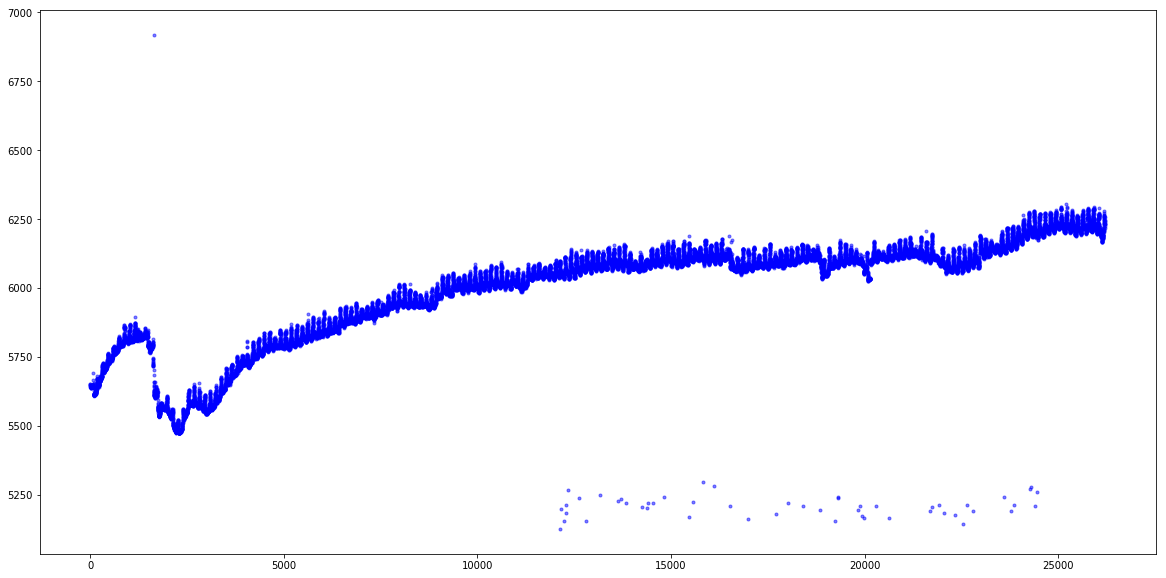

In [3]:
fig_ax = plt.figure(figsize = (20, 10))
ax_fig = fig_ax.add_subplot(111)
ax_fig.plot(df.iloc[:, 1].values, 'b.', alpha = 0.5)

# The Algorithm 

# (i). For Historical data

First let us define,

$\large d_t$ : $t^{th}$  *observation  in  the  time-series.*

$\large \eta^{ \left( k \right) } _ t = \{ d_{t-k}, d_{t-k+1}, ..., d_{t-1}, d_{t+1}, ..., d_{t+k-1}, d_{t+k} \}$

$\large w_{t-k} \left( \propto \frac{1}{d_t} \right) $ : *Weight associated with* $d_{t-k}$ *based on it's distance from d_t*.

Then calculate,

$\large\hat{d_t} = \frac{\sum_{i = t-k}^{t-1} w_i d_i + \sum_{i = t+1}^{t+k} w_i d_i}{\sum_{i = t-k}^{t-1} w_i + \sum_{i = t+1}^{t+k} w_i }$

$\large d_{t}^{\left( Conf. Int \right)} =\hat{d_t} \pm t_{{\frac{\alpha}{2}},{2k-1}} \hat{s} \sqrt{1 + \frac{1}{2k}}$ , where $t_\alpha$ is that point of a t distribution with 2k-1 degrees of freedom, such that  $\alpha$ proportion of points of the distribution lie to the right of it and $1-\alpha$ proportion of points lie to the left of it. $\large \hat{s}$ is the standard deviation of $\large \eta^{k} _t$
 

 If $\large\hat{d_t} \notin  \left[ \hat{d_t} \pm t_{{\frac{\alpha}{2}},{2k-1}} \hat{s} \sqrt{1 + \frac{1}{2k}} \right]$ then $d_t$ is deemed an outlier and is replaced by $\hat{d_t}$
 
Repeat the process for $\large d_{t+1}, d_{t+2} ...$

$k$ and $\alpha$ are parameters of the model.

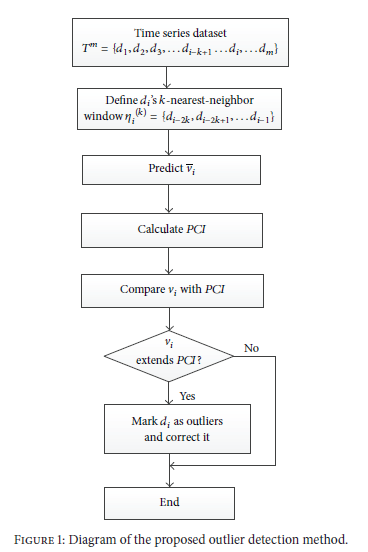

In [4]:
T = df.iloc[:, 1].values
#Function to calulate the estimate and the PCI for each observation in the time-series
def feature_extract(i, T, k, alpha):
    d_original = T[i]
    window_left = T[i-k:i]
    window_right = T[i:i+k]
    wt_right = np.arange(k, 0, -1)
    wt_left = np.arange(1, k+1, 1)
    d_estimate = ((window_left*wt_left).sum() + (window_right*wt_right).sum())/(wt_left.sum()+wt_right.sum())
    pci_l = d_estimate - t.ppf(alpha, df = 2*k-1)*(np.sqrt(1+1/(2*k)))*np.std(np.hstack((window_left, window_right)))
    pci_r = d_estimate + t.ppf(alpha, df = 2*k-1)*(np.sqrt(1+1/(2*k)))*np.std(np.hstack((window_left, window_right)))
    state = 0
    if (d_original<pci_l) or (d_original>pci_r):
        state = 1    
    dat = [d_estimate, pci_l, pci_r, state]
    return dat

# Function to compute outliers for an entire data-set
def fin_calc(T, k, alpha):
    l = np.arange(k, len(T)-k, dtype = np.int64)
    fin = map(feature_extract, l, [T]*(len(T)-2*k), [k]*(len(T)-2*k), [alpha]*(len(T)-2*k))
    df2 = pd.DataFrame(list(fin), columns = ['Estimated', 'Lower', 'Upper', 'Status'], index = range(k, len(T)-k))
    return df2

In [5]:
k = 6 
alpha = 0.95
df2 = fin_calc(T, k, alpha)

In [6]:
df2.head()

,Estimated,Lower,Upper,Status
6,5644.428571,5636.803890,5652.053253,0
7,5643.500000,5635.520784,5651.479216,0
8,5642.476190,5634.210206,5650.742175,0
9,5641.571429,5633.305444,5649.837414,0
10,5640.857143,5633.679972,5648.034314,0


In [7]:
df2 = pd.merge(df, df2, 'right', left_index = True, right_index = True)

In [8]:
df2.head()

,Timestamp,Water Level(In mm),Estimated,Lower,Upper,Status
6,2018-09-12 19:16:53,5642.0,5644.428571,5636.803890,5652.053253,0
7,2018-09-12 19:22:35,5645.0,5643.500000,5635.520784,5651.479216,0
8,2018-09-12 19:29:07,5638.0,5642.476190,5634.210206,5650.742175,0
9,2018-09-12 19:34:52,5637.0,5641.571429,5633.305444,5649.837414,0
10,2018-09-12 19:40:37,5642.0,5640.857143,5633.679972,5648.034314,0


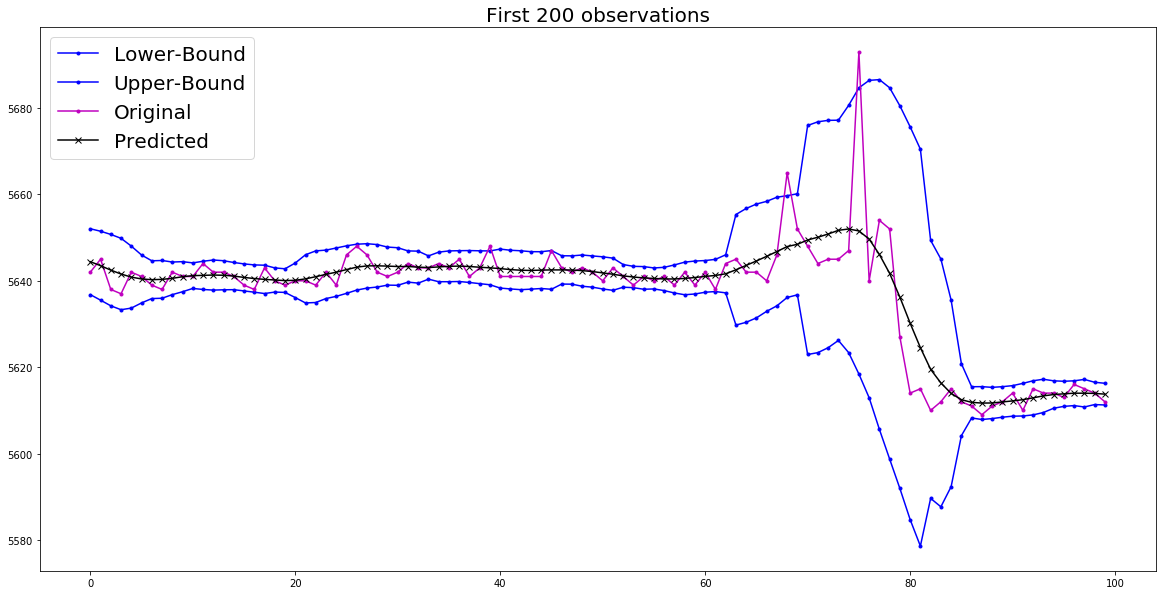

In [9]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
ax.plot(df2.iloc[:, 3].values[0:100], 'b.-', label = "Lower-Bound")
ax.plot(df2.iloc[:, 4].values[0:100], 'b.-', label = "Upper-Bound")
ax.plot(df2.iloc[:, 1].values[0:100], 'm.-', label = "Original")
ax.plot(df2.iloc[:, 2].values[0:100], 'k-x', label = "Predicted")
ax.set_title('First 200 observations', size = 20)
ax.legend(loc = "upper left", fontsize = 20)

Text(0.5, 0, '$x_t$')

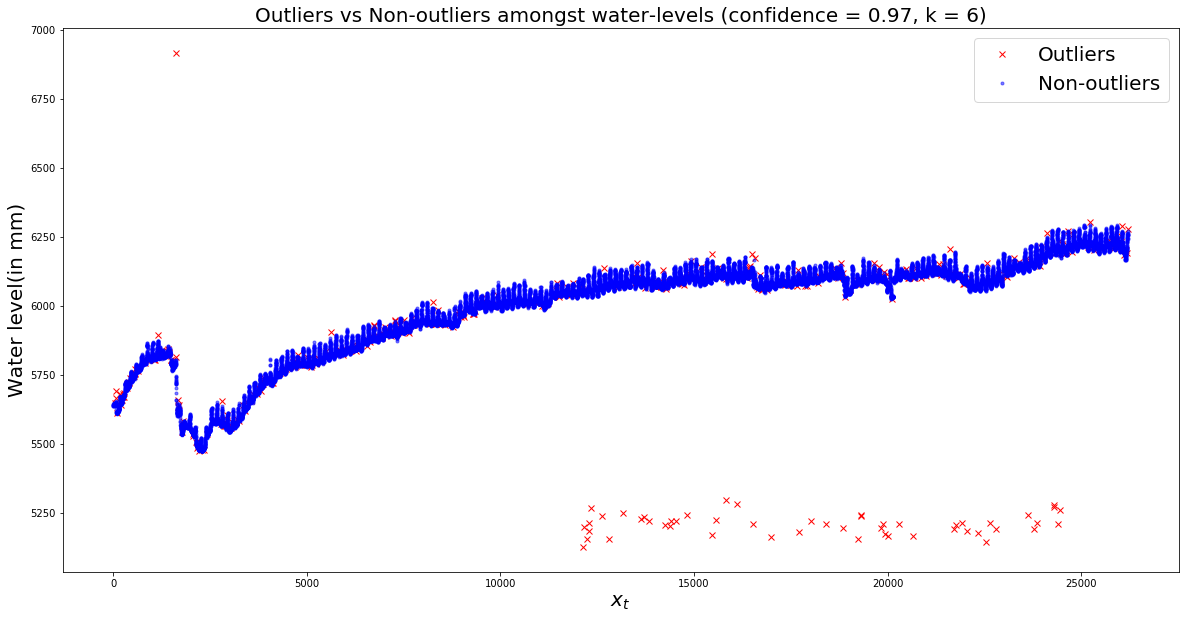

In [10]:
fig2 = plt.figure(figsize = (20, 10))
ax = fig2.add_subplot(111)
ax.plot(df2[df2.iloc[:, -1]==1].iloc[:, 1], 'rx', alpha = 1, label = 'Outliers')
ax.plot(df2[df2.iloc[:, -1]==0].iloc[:, 1], 'b.', alpha = 0.5, label = 'Non-outliers')
ax.legend(loc = 1, fontsize = 20)
ax.set_title('Outliers vs Non-outliers amongst water-levels (confidence = 0.97, k = 6)', size = 20)
ax.set_ylabel('Water level(in mm)', size = 20)
ax.set_xlabel('$x_t$', size = 20)

# (ii). For new observations.

Let us first define,

$\large d_t$ : $t^{th}$  *observation  in  the  time-series.*

$\large \eta^{ \left( k \right)}_t = \{t_{t-2k}, t_{t-2k+1}, ..., t_{t-1} \}$

$\large w_{t-k} \left( \propto \frac{1}{d_t} \right) $ : *Weight associated with* $d_{t-k}$ *based on it's distance from d_t*.

Then we calulate,

$\large\hat{d_t} = \frac{\sum_{i = t-2k}^{t-1} w_i d_i}{\sum_{i = t-2k}^{t-1} w_i}$

$\large d_{t}^{\left( Conf. Int \right)} =\hat{d_t} \pm t_{{\frac{\alpha}{2}},{2k-1}} \hat{s} \sqrt{1 + \frac{1}{2k}}$ , where $t_\alpha$ is that point of a t distribution with 2k-1 degrees of freedom, such that  $\alpha$ proportion of points of the distribution lie to the right of it and $1-\alpha$ proportion of points lie to the left of it. $\large \hat{s}$ is the standard deviation of $\large \eta^{k} _t$

If $\large\hat{d_t} \notin  \left[ \hat{d_t} \pm t_{{\frac{\alpha}{2}},{2k-1}} \hat{s} \sqrt{1 + \frac{1}{2k}} \right]$ then $d_t$ is deemed an outlier and is replaced by $\hat{d_t}$

Repeat the process for  $\large 𝑑_{𝑡+1}, 𝑑_{𝑡+2}... $
𝑘  and  𝛼  are parameters of the model.

In [11]:
def new_obs_pred(d_obs, T, k, alpha):
    d_original = d_obs[1]
    window_left = df.iloc[:, 1].values[len(df)-2*k:len(df)]
    wt_left = np.arange(1, 2*k+1)
    d_estimate = sum(window_left*wt_left)/sum(wt_left)
    pci_l = d_estimate - t.ppf(alpha, df = 2*k-1)*(np.sqrt(1+1/(2*k)))*np.std(window_left)
    pci_r = d_estimate + t.ppf(alpha, df = 2*k-1)*(np.sqrt(1+1/(2*k)))*np.std(window_left)
    state = 0.0
    if (d_original<pci_l) or (d_original>pci_r):
        state = 1.0    
    dat = [d_obs[0], d_original, d_estimate, pci_l, pci_r, state]
    return dat

In [12]:
d_obs = df.iloc[len(df)-k]
ob = new_obs_pred(d_obs, T, 6, 0.97)

Timestamp             2019-04-02 18:27:08
Water Level(In mm)                   6239
Name: 26198, dtype: object

In [14]:
df2 = df2.append(pd.Series(ob, index = df2.columns), ignore_index = True)
df.tail(5)

,Timestamp,Water Level(In mm)
26199,2019-04-02 18:37:20,6232.0
26200,2019-04-02 18:47:32,6233.0
26201,2019-04-02 18:57:44,6231.0
26202,2019-04-02 19:07:56,6224.0
26203,2019-04-02 19:18:08,6218.0


# Applying the algorithm on multiple devices.

In [15]:
a = []
file = ['02', '03', '05', '06', '07', '08', '09', '10', '11', '12']
for i in range(0, 10):
    a.append((pd.read_csv(r'E:\kritsnam data\CWC-{}.csv'.format(file[i]))).drop(columns = 'Flagged'))
#for i in a:
#    print(i.head())

In [16]:
k = 3
alpha = 0.90
for i, elem in enumerate(a):
    T = elem.iloc[:, 1].values
    d_1 = fin_calc(T, k, alpha)
    d_1 = pd.merge(elem, d_1, left_index = True, right_index = True)
    a[i] = d_1

# Visualization of the confidence intervals along with the original and predicted observations.

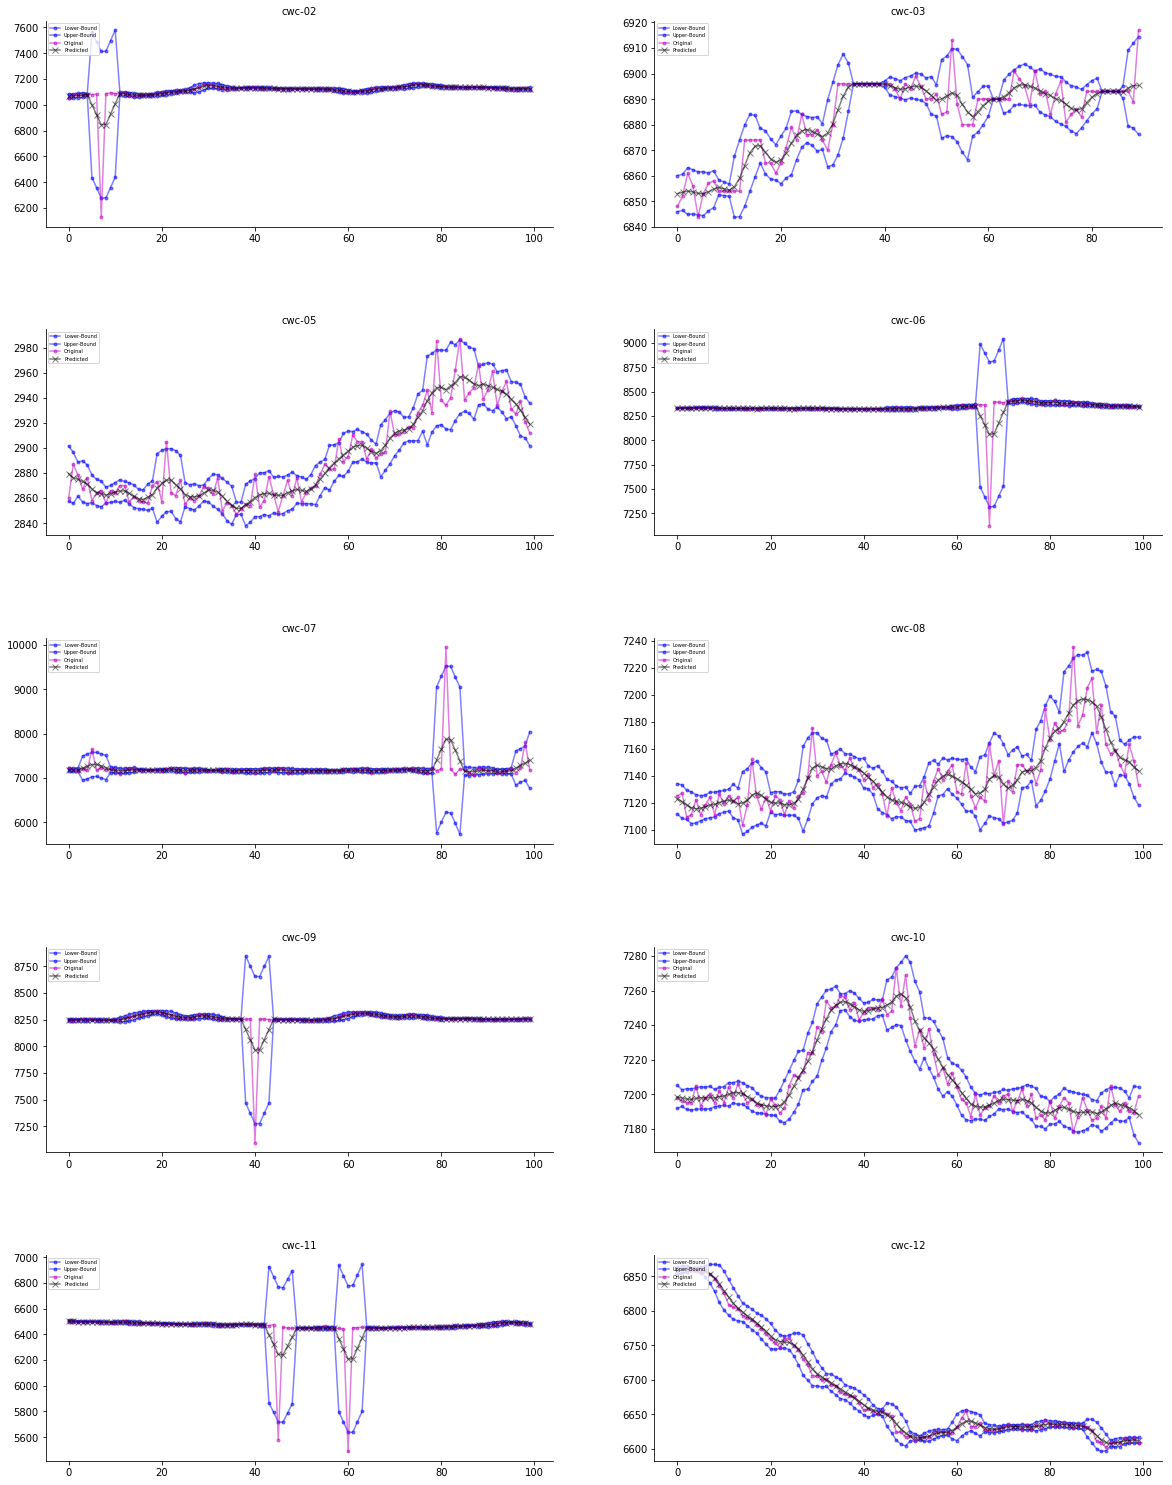

In [40]:
fig3, ax = plt.subplots(5, 2, figsize = (20, 20))
fig3.subplots_adjust(top = 2, bottom = 1, hspace = 0.5)
c = 0
for i in ax:
    for j in i:
        j.spines['top'].set_visible(False)
        j.spines['right'].set_visible(False)
        j.plot(a[c].iloc[:, 3].values[:100], 'b.-', label = "Lower-Bound", alpha = 0.5)
        j.plot(a[c].iloc[:, 4].values[:100], 'b.-', label = "Upper-Bound", alpha = 0.5) 
        j.plot(a[c].iloc[:, 1].values[:100], 'm.-', label = "Original", alpha = 0.5)
        j.plot(a[c].iloc[:, 2].values[:100], 'k-x', label = "Predicted", alpha = 0.5)
        j.set_title('cwc-{}'.format(file[c]), size = 10)
        j.legend(loc = "upper left", fontsize = 5)
        c+=1


# Visualization of the data points with outliers marked in red.

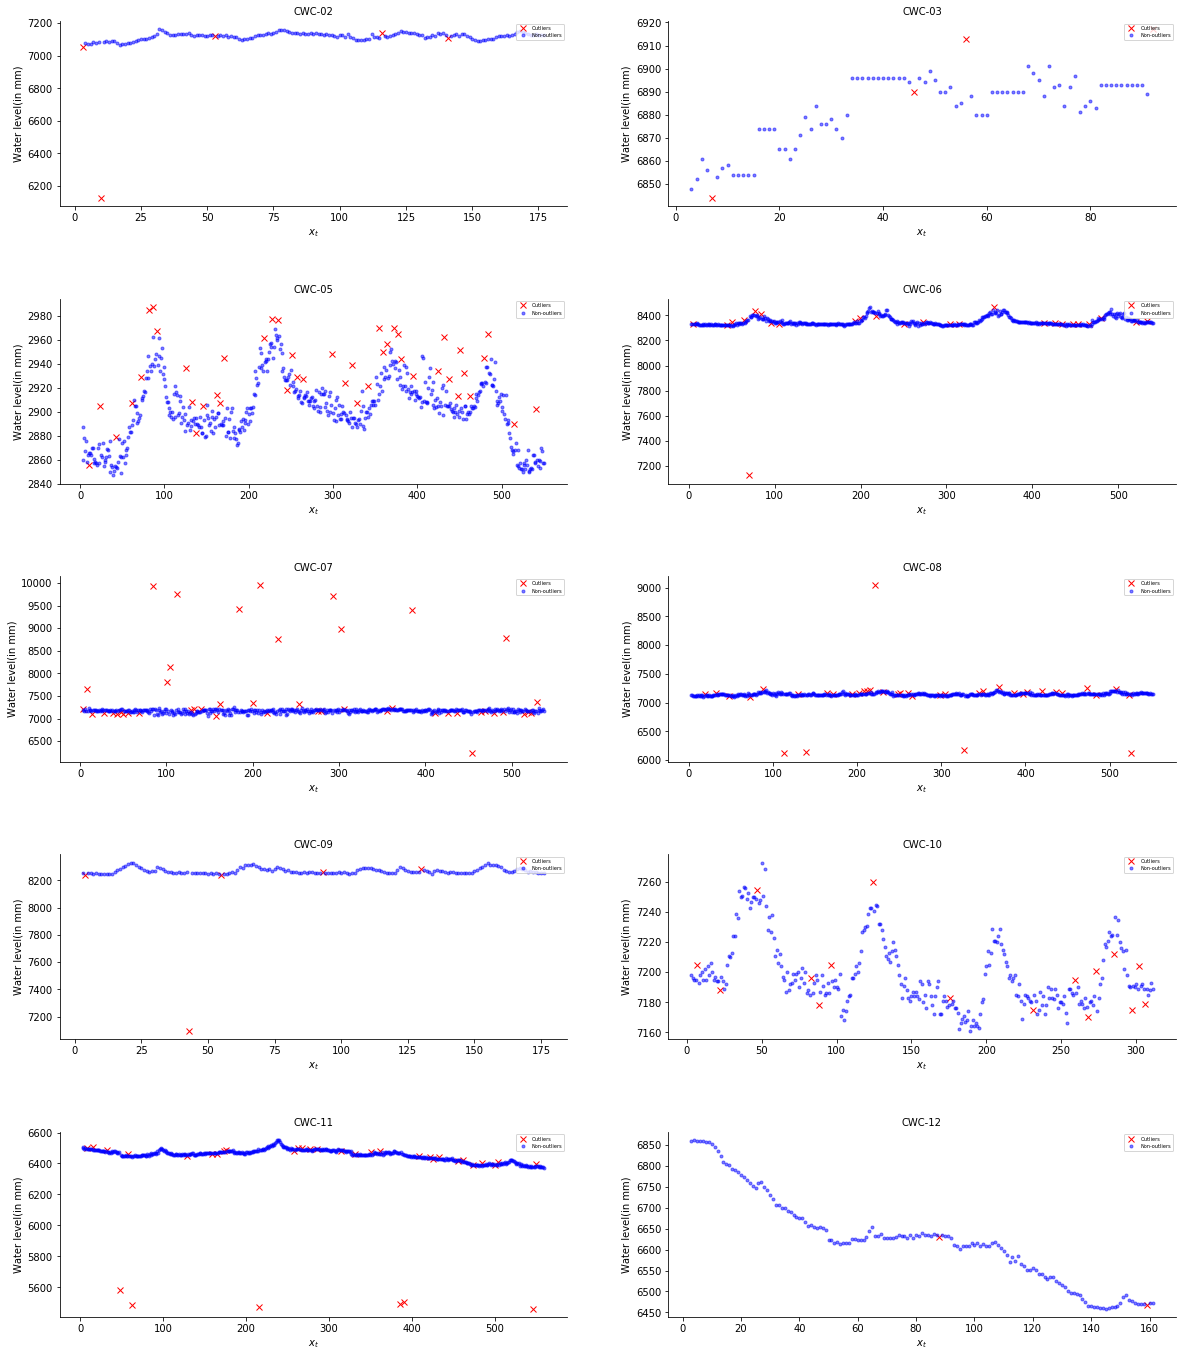

In [39]:
fig4, ax1 = plt.subplots(5, 2, figsize = (20, 20))
fig4.subplots_adjust(top = 1, bottom = 0.1, hspace = 0.5)
c = 0
for i in ax1:
    for j in i:
        j.spines['top'].set_visible(False)
        j.spines['right'].set_visible(False)
        j.plot(a[c][a[c].iloc[:, -1]==1].iloc[:, 1], 'rx', alpha = 1, label = 'Outliers')
        j.plot(a[c][a[c].iloc[:, -1]==0].iloc[:, 1], 'b.', alpha = 0.5, label = 'Non-outliers')
        j.legend(loc = 1, fontsize = 5)
        j.set_title('CWC-{}'.format(file[c]), size = 10)
        j.set_ylabel('Water level(in mm)', size = 10)
        j.set_xlabel('$x_t$', size = 10)
        c+=1